# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split,GroupShuffleSplit,KFold
import cv2
from torchvision import transforms
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torchvision.models as models
import torch
from torch import nn
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,\
    ConfusionMatrixDisplay,accuracy_score,cohen_kappa_score,roc_auc_score,\
        roc_curve
import copy
import tqdm
import json
import time
from collections import defaultdict
from torch.optim import lr_scheduler
from torchvision.datasets import MNIST
from torch.utils.data import WeightedRandomSampler,SubsetRandomSampler
from efficientnet_pytorch import EfficientNet
from torchvision.datasets import MNIST
from sklearn.utils import class_weight
import wandb
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2
import albumentations as A
import gc
from patchify import patchify
from torchsummary import summary

import statistics as stat
import matplotlib.patches as mpatches
%reload_ext autoreload
%autoreload 2

/u/spa-d2/grad/mah259/anaconda3/envs/research/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Compare among runs

In [2]:
run_ids=['8v7x97ms','fha4e6zv']
run_names=['cos scheduler + adamw',' without cropping cos scheduler']
plt_name="Comparison between\n Cos scheduler with adamw and without cropping and without adamw"
metrics=['Loss','Kappa']

In [4]:
api = wandb.Api()
means=[]
stdevs=[]
for cur_run_id in run_ids:
    art = api.artifact('chill-cga/midrc-challenge-2023/run-'+cur_run_id+'-ValTable:latest')
    table = art.get("Val Table")
    means.append(table.data[5][1:])
    stdevs.append(table.data[6][1:])

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [5]:
print(means)
print(stdevs)

[[0.040698062628507614, 0.7708765164001796], [0.041599708050489424, 0.7645406442096966]]
[[0.004679740158324468, 0.033296119050771664], [0.0035118108605411637, 0.03699761389651965]]


[1, 2, 4, 5]
[0.040698062628507614, 0.041599708050489424, 0.7708765164001796, 0.7645406442096966]
[0.004679740158324468, 0.0035118108605411637, 0.033296119050771664, 0.03699761389651965]
[1.5, 4.5]


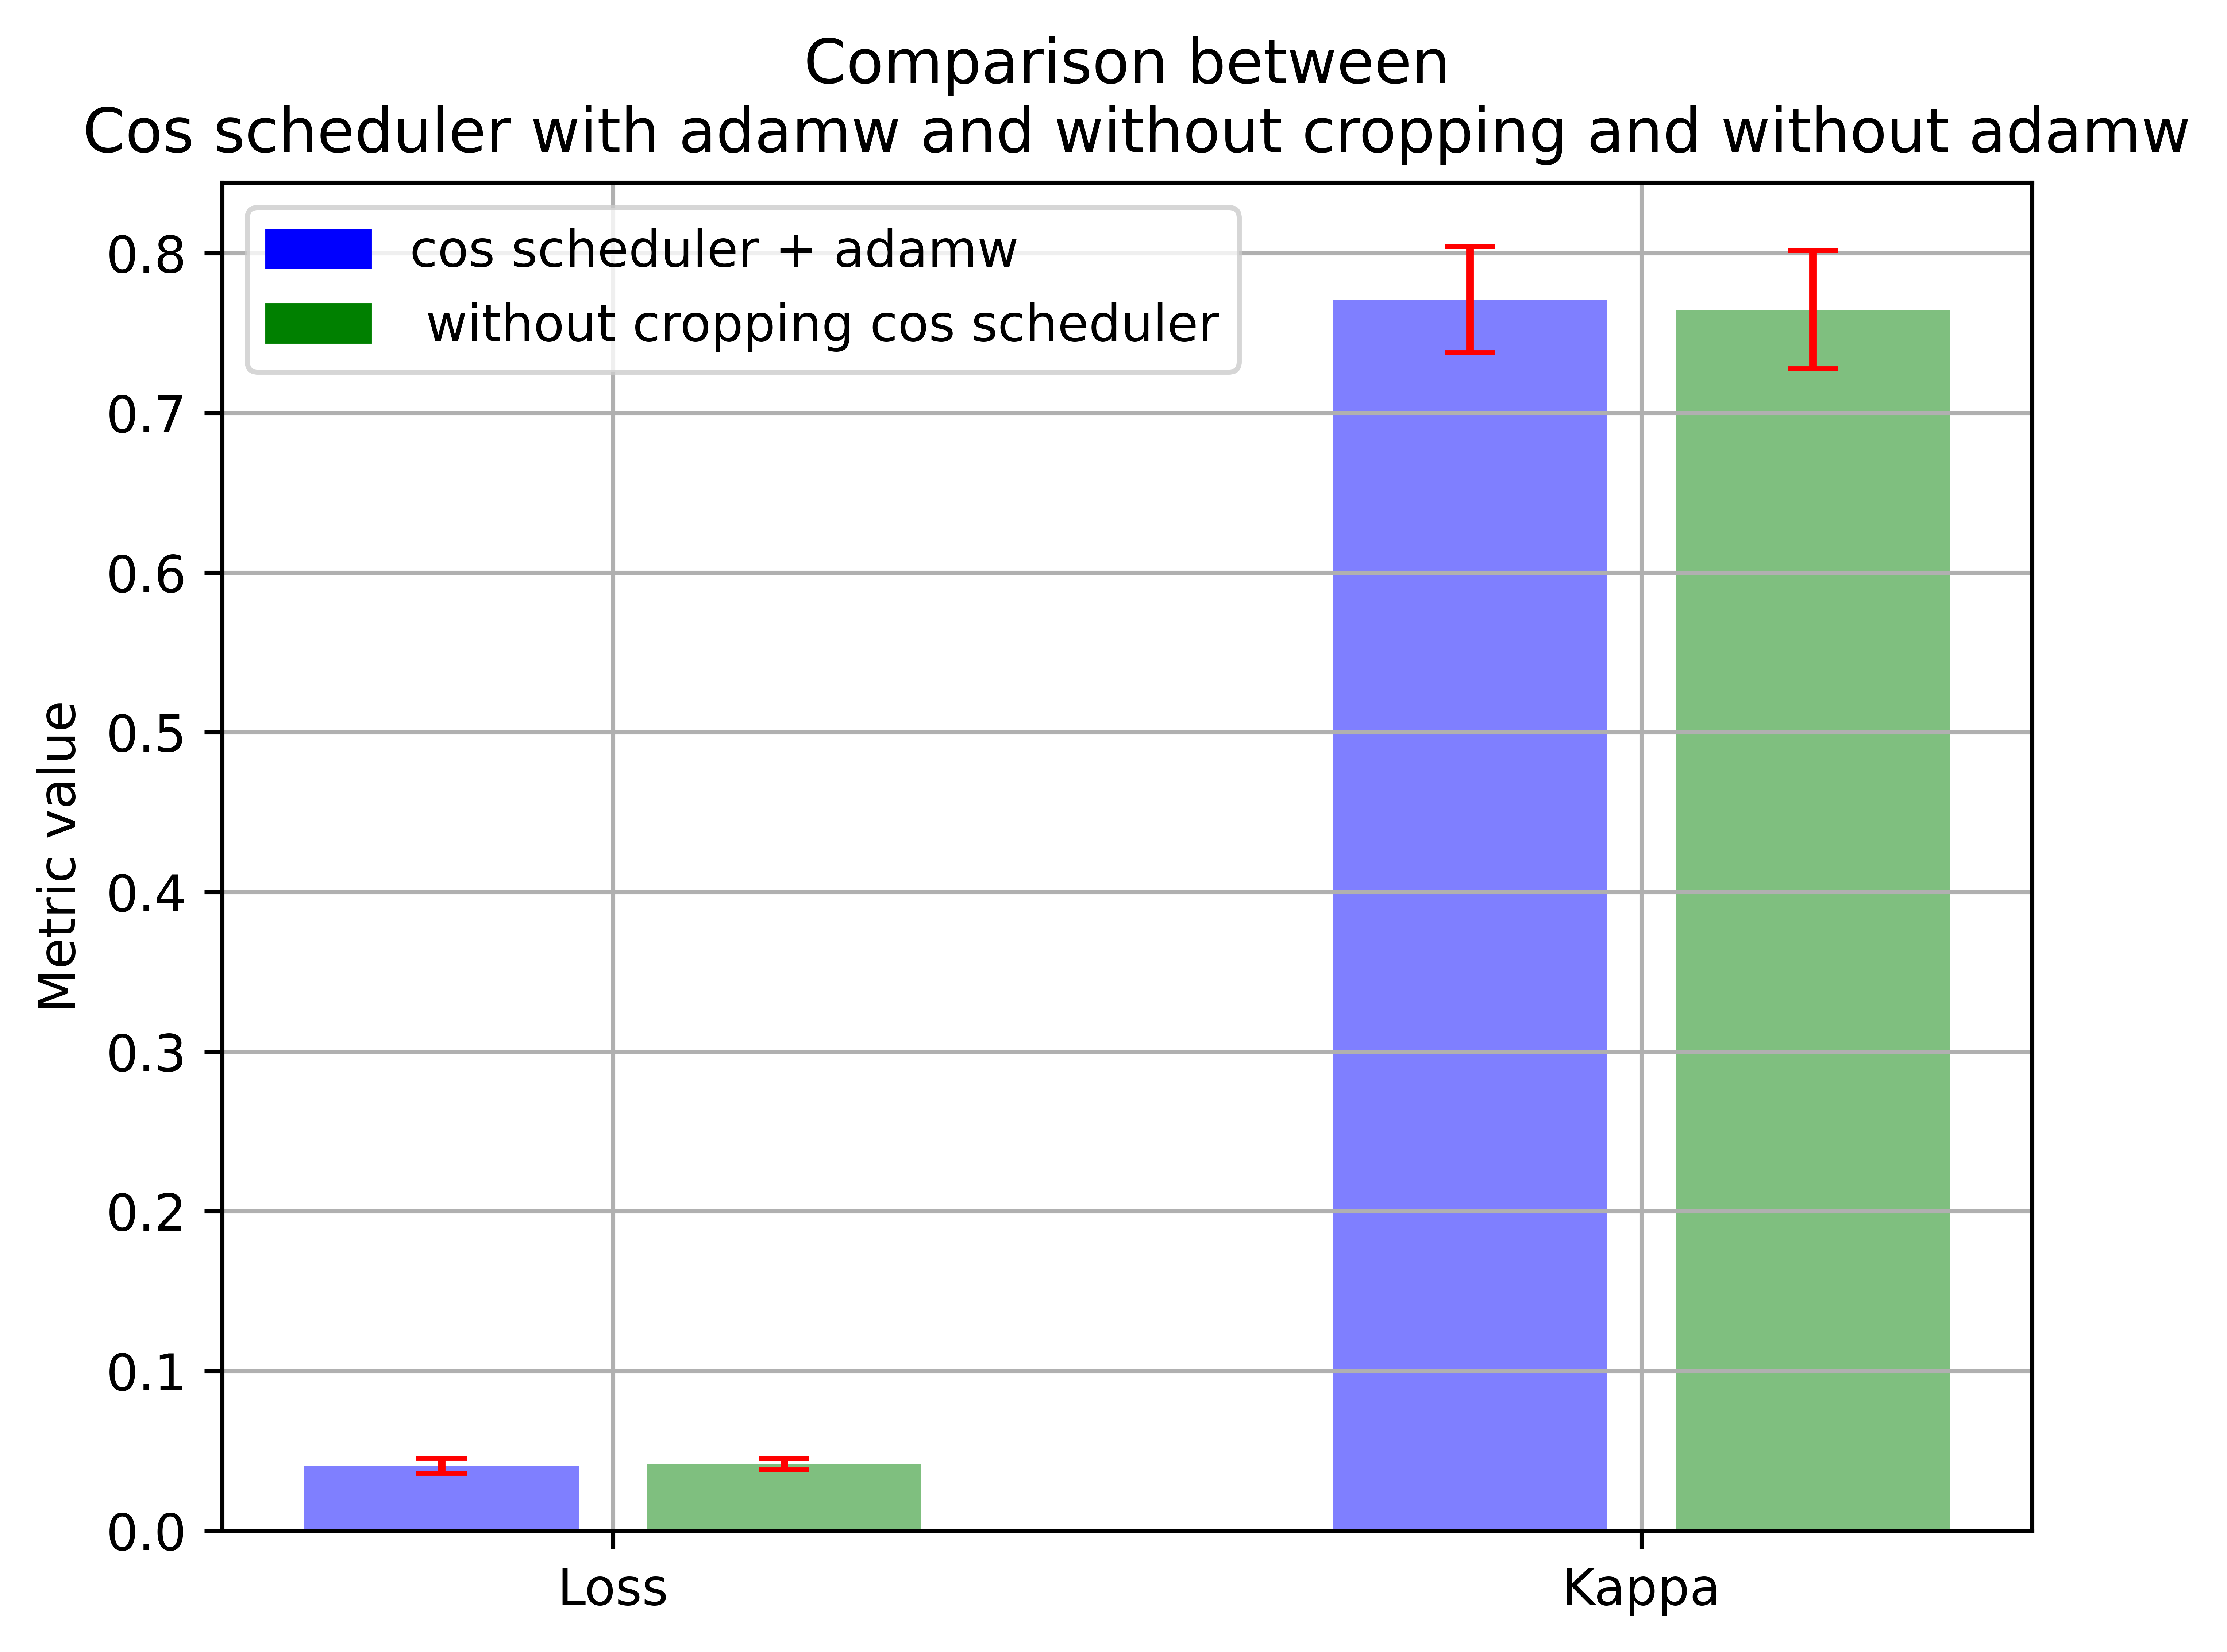

In [7]:
some_colors=['blue','green','purple']
plt.figure(dpi=1000)
x_pos=[]
for i in range(len(run_ids)*len(metrics)+len(metrics)):
    if i==0:
        continue
    if i%(len(run_ids)+1)==0:
        continue
    else:
        x_pos.append(i)
print(x_pos)
colors=[]
for i in range(len(x_pos)):
    colors.append(some_colors[i%len(run_ids)])
to_plot_means=[]
to_plot_stdevs=[]
for i in range(len(metrics)):
    for j in range(len(run_ids)):
        # print(j,i)
        to_plot_means.append(means[j][i])
        to_plot_stdevs.append(stdevs[j][i])
print(to_plot_means)
print(to_plot_stdevs)
plt.bar(x_pos, to_plot_means, yerr=to_plot_stdevs, align='center', alpha=0.5, ecolor='red', capsize=5,color=colors)

x_tick_locs=[]
for i in range(len(metrics)):
    cur_avg_loc=0
    for j in range((i*len(run_ids)),i*len(run_ids)+len(run_ids)):
        cur_avg_loc+=x_pos[j]
    x_tick_locs.append(cur_avg_loc/len(run_ids))
print(x_tick_locs)
plt.xticks(x_tick_locs,['Loss','Kappa'])
# ax.set_xticklabels(materials)

plt.ylabel("Metric value")
legends=[]
for i in range(len(run_ids)):
    legend_temp = mpatches.Patch(color=some_colors[i], label=run_names[i])
    legends.append(legend_temp)
plt.legend(handles=legends)
plt.grid(True)
plt.title(plt_name)
# # Save the figure and show
# plt.tight_layout()
fig_save_string='compare_results/comparison of'
for cur_id in run_ids:
    fig_save_string+='_'+cur_id

fig_save_string+='.png'

# plt.savefig(fig_save_string)
plt.show()